# Trying out a web classifier
- Using the **20news groups** dataset
- Can also build a training data based on keyword search and then train a model on it. 
- CLASSES - 
    1. DATA STRUCTURES AND ALGOS
    2. SOCIAL SCIENCE
    3. AI AND ML
    4. WEB DEV
    5. MANAGEMENT
    6. MARKETING
    
   

In [9]:
import pandas as pd
import time
import csv 
import gzip
import bs4
import requests
import numpy as np
import matplotlib.pyplot as plt
from googlesearch import search
import concurrent.futures

## KEYWORD LISTS BASED
- We will try to make a keyword set for each of these categories.
- Now, we will get a lot of pages from WARC and analyse their text. 

- For a page P 
    - We will make a hit count table for each of the keywords which we have matched.
    - After this, there will be a voting phase. 
    - For each of the classes, we will club their keyword dicts and see whether the page would belong to this particular category or not. 
    - We take the HM of the freq distribution and whichever has the highest, will be set as the class label. 
    
    
- Now, this will generate the labelled dataset for our classifier. Although it may be biased towards the keywords but the point is that the pages containing these keywords would contain other words also, related to the class label.

- This would further populate the dictionary. 

> source : https://www.wordstream.com/popular-keywords/business-management-keywords
   

### Getting the URLs and their text via Google

> docs : https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list

> docs : https://www.geeksforgeeks.org/performing-google-search-using-python-code/

-  We can use the custom search engine to get the query results from google 
- We can enter the keywords which MUST be present in the web pages and then we let google rank the pages and give them to us
- We extract ~ 400 pages for each domain which we are trying to solve for 
- Then train a machine learning model over the extracted text from these pages and the class labels.
- After this, any url would be given to us and we would go to its page, get the text, transform it and classify the page as 1 of the class labels

In [96]:
key_words = {
    "ml" : ["Machine Learning ","machinelearning regression classfication recommender AI trainingdata intelligence data"],
    "dsa" : ["Data Structures and Algorithms","algorithms binarytree hashing string datastructure graphs memory programming timecomplexity"],
    "social-science" : ["Social Science", "Sociology Geography Psychology CognitiveScience Economics History Social Welfare Inequality"],
    "web-dev" : ["Web Development", "graphicdesign reactjs websitedesign websitebuilder webdeveloper designer webdesign ecommercecompany creator responsive"],
   "management" : ["Management", "business management mba administration manager strategy degree process international" ]
}



In [86]:
# set 
done = {"ml"}

In [87]:
key = input("Enter key :")

if key not in key_words:
    print("Invalid")
else:
    if key in done:
        print("Already done")
    else:
        key_word = key_words[key]

        print("Searching for ",key, " with",key_word)
        
        # file info 
        file_path = "data/distinct-tables/" + key + ".csv"
        file = open(file_path, 'a', encoding = 'utf-8', newline = '')
        for query in key_word[1].split():
            print(f"Query is {query}")

            # search for this query 
            for res in search(query, num = 30, tld = 'com', stop = 30, pause = 15):
                file.write(res+'\n')
            print("Completed...")

        print("Completed extraction for", key_word[0])
        done.add(key)
        
    

Enter key :dsa
Searching for  dsa  with ['Data Structures and Algorithms', 'algorithms binarytree string datastructure graph memory programming timecomplexity']
Query is algorithms
Completed...
Query is binarytree
Completed...
Query is string
Completed...
Query is datastructure
Completed...
Query is graph
Completed...
Query is memory
Completed...
Query is programming
Completed...
Query is timecomplexity
Completed...
Completed extraction for Data Structures and Algorithms


### Utils

In [88]:
def get_html(url):
    r = requests.get(url)
    return r.content

def get_text(url):
    html_content = get_html(url)
    soup = bs4.BeautifulSoup(html_content)

    # strip all script and style elements
    for script in soup(["script", "style"]):
        script.decompose()

    return soup.get_text(" ", strip=True)

In [89]:
def get_text_p(url, class_label, i, df_dict):
    html_content = get_html(url)
    soup = bs4.BeautifulSoup(html_content)

    # strip all script and style elements
    for script in soup(["script", "style"]):
        script.decompose()

    url_text = soup.get_text(" ", strip=True)
    df_dict[i] = [url, url_text, class_label]
    
    return 

## Extract Texts

In [90]:
text_done = {"web-dev","management"}

### Parallel

In [91]:
df_dict = {}
i = 0
NUM_THREADS = 25

key = input("Enter key :")

if key not in key_words:
    print("Invalid")
else:
    if key in text_done:
        print("Already done")
    else:
        key_word = key_words[key]
        file_path = "data/distinct-tables/" + key + ".csv"
        data = pd.read_csv(file_path)
        class_label = key_word[0]

        print("Extracting for class_label : ",class_label)
        # for each row in the data
        
        completed = False 
        start = 0
        increment = NUM_THREADS 
        
        while start < len(data):
            
            print("Submitting threads...")
            with concurrent.futures.ThreadPoolExecutor(max_workers = NUM_THREADS) as executor:
                # get the urls 
                url_range = data["Url"][start : start + increment]
                for url in url_range:
                    executor.submit(get_text_p, url, class_label, i, df_dict)
                    # delete very large elements 
                    i+=1
            
#             for uid in range(start, start+increment):
#                 if len(df_dict[uid]) > 1e7:
#                     del df_dict[uid] 
            
            print("All threads completed!")
            print(f"Completed {start} to {start + increment}...")
            start += increment 
    

        final_dataframe = pd.DataFrame.from_dict(df_dict, orient = 'index')
        final_dataframe.columns = ["url", "text", "class"]
        print(final_dataframe.head(n = 3))
        
        # save the file to disk 
        final_dataframe.to_csv("data/text-data/"+key+".csv")
        

        # done for key 
        text_done.add(key)
        print("Completed text extraction!")

Enter key :dsa
Extracting for class_label :  Data Structures and Algorithms
Submitting threads...
All threads completed!
Completed 0 to 25...
Submitting threads...
All threads completed!
Completed 25 to 50...
Submitting threads...


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


All threads completed!
Completed 50 to 75...
Submitting threads...
All threads completed!
Completed 75 to 100...
Submitting threads...
All threads completed!
Completed 100 to 125...
Submitting threads...
All threads completed!
Completed 125 to 150...
Submitting threads...
All threads completed!
Completed 150 to 175...
Submitting threads...


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


All threads completed!
Completed 175 to 200...
Submitting threads...
All threads completed!
Completed 200 to 225...
Submitting threads...
All threads completed!
Completed 225 to 250...
Submitting threads...
All threads completed!
Completed 250 to 275...
Submitting threads...
All threads completed!
Completed 275 to 300...
Submitting threads...
All threads completed!
Completed 300 to 325...
Submitting threads...


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


All threads completed!
Completed 325 to 350...
Submitting threads...
All threads completed!
Completed 350 to 375...
Submitting threads...


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


All threads completed!
Completed 375 to 400...
Submitting threads...
All threads completed!
Completed 400 to 425...
Submitting threads...
All threads completed!
Completed 425 to 450...
                                                  url  \
17  https://practice.geeksforgeeks.org/courses/dsa...   
12  https://www.amazon.com/Data-Structures-Algorit...   
8   https://www.amazon.com/Algorithms-Structures-P...   

                                                 text  \
17  Courses | Data Structures and Algorithms - Sel...   
12                       Sorry! Something went wrong!   
8                        Sorry! Something went wrong!   

                             class  
17  Data Structures and Algorithms  
12  Data Structures and Algorithms  
8   Data Structures and Algorithms  
Completed text extraction!


### sequential

In [ ]:
df_dict = {}

key = input("Enter key :")

if key not in key_words:
    print("Invalid")
else:
    if key in text_done:
        print("Already done")
    else:
        key_word = key_words[key]
        i = 0
        
        # pick url file 
        file_path = "data/distinct-tables/" + key + ".csv"
        data = pd.read_csv(file_path)
        class_label = key_word[0]
        
        # for each row in the data
        all_urls = data["Url"]
        for uid,url in enumerate(all_urls):
            try:
                url_text = get_text(url)
                if len(url_text) > 1e7:
                    continue
                df_dict[i] = [url, url_text, class_label]
                i+=1

                if i % 10 == 0:
                    print(f"Completed {i} requests...")
            except:
                continue 

        # simple sequential building of df 
        final_dataframe = pd.DataFrame.from_dict(df_dict, orient = 'index')
        final_dataframe.columns = ["url", "text", "class"]
        print(final_dataframe.head())

        # save it 
        final_dataframe.to_csv("data/text-data/"+key+".csv")
    

### Combine all the dataframes into 1 

In [99]:
data_frames = []
keys = key_words.keys()
to_drop = ["index", "Unnamed: 0"]

# get the dataframes 
for name in keys:
    text_path = "data/text-data/"+ name +".csv"
    frame = pd.read_csv(text_path)
    frame = frame.reset_index()
    frame = frame.drop(to_drop, axis = 1)
    print("Dataframe :",name)
    display(frame.head(n = 5))
    data_frames.append(frame)
    
final_dataframe = pd.DataFrame(columns= ["url", "text", "class"])
final_df = pd.concat(data_frames)

Dataframe : ml


,url,text,class
0,https://www.geeksforgeeks.org/machine-learning/,Machine Learning - GeeksforGeeks Skip to conte...,Machine Learning
1,https://machinelearningmastery.com/start-here/,Just a moment... machinelearningmastery.com Ch...,Machine Learning
2,https://www.techtarget.com/searchenterpriseai/...,What Is Machine Learning and Why Is It Importa...,Machine Learning
3,https://azure.microsoft.com/en-us/services/mac...,Azure Machine Learning - ML as a Service | Mic...,Machine Learning
4,https://ai.google/education/,Education – Google AI AI AI About Responsibili...,Machine Learning


Dataframe : dsa


,url,text,class
0,https://practice.geeksforgeeks.org/courses/dsa...,Courses | Data Structures and Algorithms - Sel...,Data Structures and Algorithms
1,https://www.amazon.com/Data-Structures-Algorit...,Sorry! Something went wrong!,Data Structures and Algorithms
2,https://www.amazon.com/Algorithms-Structures-P...,Sorry! Something went wrong!,Data Structures and Algorithms
3,https://www.geeksforgeeks.org/data-structures/,Data Structures - GeeksforGeeks Skip to conten...,Data Structures and Algorithms
4,https://blog.pragmaticengineer.com/data-struct...,Data Structures & Algorithms I Used Working at...,Data Structures and Algorithms


Dataframe : social-science


,url,text,class
0,https://www.wada-ama.org/en/data-research/soci...,Social Science Research | World Anti-Doping Ag...,Social Science
1,https://journals.sagepub.com/home/ssc,Just a moment... journals.sagepub.com Checking...,Social Science
2,https://www.science.org/doi/10.1126/science.11...,Just a moment... www.science.org Checking if t...,Social Science
3,https://www.aclu.org/careers/apply/?job=630743...,Careers at ACLU | American Civil Liberties Uni...,Social Science
4,https://www.britannica.com/topic/social-science,"social science | History, Disciplines, Future ...",Social Science


Dataframe : web-dev


,url,text,class
0,https://developer.mozilla.org/,MDN Web Docs Skip to main content Skip to sear...,Web Development
1,https://www.freecodecamp.org/learn/responsive-...,freeCodeCamp is a donor-supported tax-exempt 5...,Web Development
2,https://developer.mozilla.org/en-US/docs/Learn,Learn web development | MDN Skip to main conte...,Web Development
3,https://www.coursera.org/specializations/web-d...,Web Design for Everybody: Basics of Web Develo...,Web Development
4,https://web.dev/,web.dev Skip to content Open menu Learn Measur...,Web Development


Dataframe : management


,url,text,class
0,https://www.pmi.org/,Just a moment... www.pmi.org Checking if the s...,Management
1,https://thunderbird.asu.edu/,Thunderbird School of Global Management Global...,Management
2,https://hbr.org/,Harvard Business Review - Ideas and Advice for...,Management
3,https://monday.com/blog/project-management/pro...,What is Process Management? | monday.com Blog ...,Management
4,https://www.netsuite.com/portal/home.shtml,"Business Software, Business Management Softwar...",Management


In [100]:
try:
    final_df.reset_index(inplace = True)
    final_df = final_df.drop(["index"], axis = 1)
except:
    pass 

final_df

,url,text,class
0,https://www.geeksforgeeks.org/machine-learning/,Machine Learning - GeeksforGeeks Skip to conte...,Machine Learning
1,https://machinelearningmastery.com/start-here/,Just a moment... machinelearningmastery.com Ch...,Machine Learning
2,https://www.techtarget.com/searchenterpriseai/...,What Is Machine Learning and Why Is It Importa...,Machine Learning
3,https://azure.microsoft.com/en-us/services/mac...,Azure Machine Learning - ML as a Service | Mic...,Machine Learning
4,https://ai.google/education/,Education – Google AI AI AI About Responsibili...,Machine Learning
...,...,...,...
2028,https://nodejs.org/api/process.html,Process | Node.js v18.9.0 Documentation Node.j...,Management
2029,https://www.dictionary.com/browse/international,International Definition & Meaning | Dictionar...,Management
2030,https://www.imf.org/en/Home,International Monetary Fund - Homepage About F...,Management
2031,https://www.processmodel.com/blog/what-is-a-pr...,What is a Process? • ProcessModel Skip to cont...,Management


In [101]:
final_df.to_csv("data/final_dataframe.csv")

### Class Distribution

<BarContainer object of 5 artists>

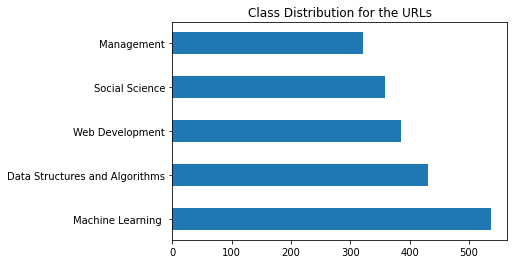

In [102]:
plt.title("Class Distribution for the URLs")
plt.barh(width = final_df["class"].value_counts().values, height = 0.5, y = final_df["class"].value_counts().keys())

In [ ]:
init_data = pd.read_csv('data/website_classification.csv', low_memory=False)
init_data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
init_data

### Pre - Processing 
-  Note : model does not have any kind of relation with the url
- It only wants the textual information for the prediction
- We only need the associations 


In [ ]:
data = init_data.drop(axis=1, labels=["website_url"])
# no req of url
data.head()

In [ ]:
# example text
data["cleaned_website_text"][1121]

In [ ]:
# now we remove the stop words, remove abbreviations and lemmatize the text
# to do

In [ ]:
# after the processing, we will vectorize the text corpus using tfidf and encode the class labels with ints

In [ ]:
# then train a model

In [ ]:
# to do...

### Testing 
- Take a url, and get its html page 
- Parse the page and extract the text 
- Put the text through the data processing pipeline and transform according to the model 
- Now predict the top 5 classes for the url text and return the top one 

In [ ]:
# pass through pipeline and then predict the class label